In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [47]:
# Read the CSV file
df = pd.read_csv('diabetes_prediction_dataset.csv')
print(df.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


In [48]:
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
print(df_encoded.head())

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Male  gender_Other  smoking_history_current  \
0         0            0             0                        0   
1         0            0             0                        0   
2         0            1             0                        0   
3         0            0             0                        1   
4         0            1             0                        1   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                     0             

In [49]:
testDF = df_encoded
testDF = testDF.sample(frac=1).reset_index(drop=True)
x_unscaled = testDF.drop(['diabetes'], axis=1)
y = testDF['diabetes']

# Normalize the data
numerical_columns = x_unscaled.select_dtypes(include=np.number).columns
boolean_columns = x_unscaled.select_dtypes(include=bool).columns

scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_unscaled[numerical_columns]), columns=numerical_columns)
x_scaled = pd.concat([temp, x_unscaled[boolean_columns]], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

Using device: cuda
Model files do not exist. Training new models...
Epoch [1/50], Encoder Loss: 0.9688
Validation Loss: 0.9971
Epoch [2/50], Encoder Loss: 0.8418
Validation Loss: 0.8681
Epoch [3/50], Encoder Loss: 0.7573
Validation Loss: 0.8032
Epoch [4/50], Encoder Loss: 0.7109
Validation Loss: 0.7709
Epoch [5/50], Encoder Loss: 0.6888
Validation Loss: 0.7517
Epoch [6/50], Encoder Loss: 0.6724
Validation Loss: 0.7372
Epoch [7/50], Encoder Loss: 0.6623
Validation Loss: 0.7280
Epoch [8/50], Encoder Loss: 0.6549
Validation Loss: 0.7204
Epoch [9/50], Encoder Loss: 0.6488
Validation Loss: 0.7142
Epoch [10/50], Encoder Loss: 0.6435
Validation Loss: 0.7093
Epoch [11/50], Encoder Loss: 0.6386
Validation Loss: 0.7042
Epoch [12/50], Encoder Loss: 0.6344
Validation Loss: 0.7000
Epoch [13/50], Encoder Loss: 0.6306
Validation Loss: 0.6964
Epoch [14/50], Encoder Loss: 0.6273
Validation Loss: 0.6931
Epoch [15/50], Encoder Loss: 0.6241
Validation Loss: 0.6891
Epoch [16/50], Encoder Loss: 0.6208
Valid

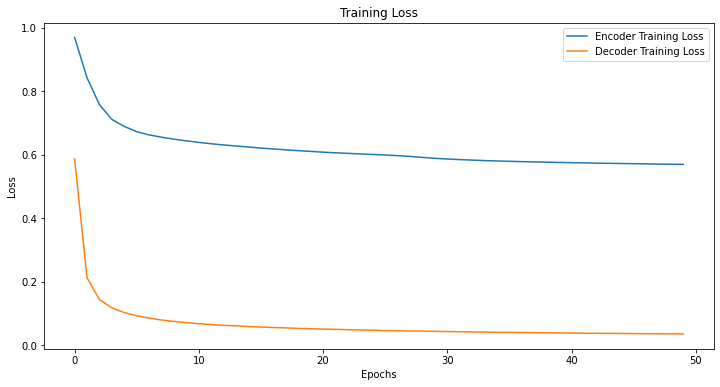

In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check if CUDA is available and print the device being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Encoder model with reduced complexity and dropout
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, encoding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Define the Decoder model with reduced complexity and dropout
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        return self.decoder(x)

# Load and preprocess data
# Assuming x_train, x_test, y_train, and y_test are already defined and normalized
x_train_scaled = x_train.values if isinstance(x_train, pd.DataFrame) else x_train
x_test_scaled = x_test.values if isinstance(x_test, pd.DataFrame) else x_test

# Define input dimensions
input_dim = x_train.shape[1]

# Model file paths
encoder_model_file = './models/encoder2.pth'
decoder_model_file = './models/decoder2.pth'

# Hyperparameters
encoding_dim = 8
learning_rate = 0.00005
epochs = 50  # Reduced epochs for quick testing
batch_size = 16  # Reduced batch size to reduce memory usage
accumulation_steps = 2  # Gradient accumulation steps
patience = 5  # Early stopping patience

# Check if the model files exist
if os.path.exists(encoder_model_file) and os.path.exists(decoder_model_file):
    print("Model files exist. Loading the models...")
    encoder = Encoder(input_dim, encoding_dim).to(device)
    decoder = Decoder(encoding_dim, input_dim).to(device)
    encoder.load_state_dict(torch.load(encoder_model_file))
    decoder.load_state_dict(torch.load(decoder_model_file))
else:
    print("Model files do not exist. Training new models...")

    # Initialize the encoder and decoder models
    encoder = Encoder(input_dim, encoding_dim).to(device)
    decoder = Decoder(encoding_dim, input_dim).to(device)
    optimizer_encoder = optim.Adam(encoder.parameters(), lr=learning_rate)
    optimizer_decoder = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Track training loss
    encoder_losses = []
    decoder_losses = []

    # Train the Encoder separately
    encoder.train()
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        dataloader = DataLoader(TensorDataset(torch.tensor(x_train_scaled, dtype=torch.float32).to(device), torch.tensor(x_train_scaled, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True, num_workers=0)
        for i, (batch_X, _) in enumerate(dataloader):
            batch_X = batch_X.to(device)
            optimizer_encoder.zero_grad()
            encoded = encoder(batch_X)
            # Pass the encoded output through the decoder
            decoded = decoder(encoded)
            # Calculate loss between decoder output and original input
            loss = criterion(decoded, batch_X)
            loss.backward()
            
            if (i + 1) % accumulation_steps == 0:
                optimizer_encoder.step()
                optimizer_encoder.zero_grad()
            
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        encoder_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Encoder Loss: {avg_loss:.4f}")

        # Validation loss
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            val_encoded = encoder(torch.tensor(x_val, dtype=torch.float32).to(device))
            val_decoded = decoder(val_encoded)
            val_loss = criterion(val_decoded, torch.tensor(x_val, dtype=torch.float32).to(device)).item()
        print(f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Train the Decoder separately
    encoded_train = encoder(torch.tensor(x_train_scaled, dtype=torch.float32).to(device)).detach()
    decoder.train()
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        dataloader = DataLoader(TensorDataset(encoded_train, torch.tensor(x_train_scaled, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True, num_workers=0)
        for i, (batch_X, batch_y) in enumerate(dataloader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer_decoder.zero_grad()
            outputs = decoder(batch_X)
            # Calculate loss between decoder output and original input
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            if (i + 1) % accumulation_steps == 0:
                optimizer_decoder.step()
                optimizer_decoder.zero_grad()
            
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        decoder_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Decoder Loss: {avg_loss:.4f}")

        # Validation loss
        decoder.eval()
        with torch.no_grad():
            val_outputs = decoder(encoded_train)
            val_loss = criterion(val_outputs, torch.tensor(x_train_scaled, dtype=torch.float32).to(device)).item()
        print(f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Save the trained models
    os.makedirs('./models', exist_ok=True)
    torch.save(encoder.state_dict(), encoder_model_file)
    torch.save(decoder.state_dict(), decoder_model_file)
    print("Models trained and saved.")

# Combine Encoder and Decoder to form the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(encoder, decoder).to(device)
autoencoder.eval()

# Calculate reconstruction error on the test set
with torch.no_grad():
    reconstructed_test = autoencoder(torch.tensor(x_test_scaled, dtype=torch.float32).to(device)).cpu().numpy()

# Calculate Mean Squared Error (MSE)
mse = np.mean((x_test_scaled - reconstructed_test) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(x_test_scaled - reconstructed_test))
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Reconstruction Error Percentage
reconstruction_error = np.mean(np.square(x_test_scaled - reconstructed_test), axis=1)
reconstruction_error_percentage = np.mean(reconstruction_error) * 100
print(f'Reconstruction Error Percentage: {reconstruction_error_percentage}')

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(encoder_losses, label='Encoder Training Loss')
plt.plot(decoder_losses, label='Decoder Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

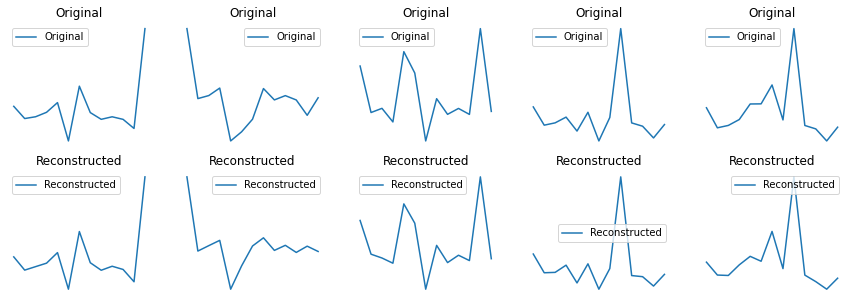

In [51]:
# Visualize some of the original and reconstructed samples
num_samples = 5
fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

for i in range(num_samples):
    # Original sample
    axes[0, i].plot(x_test_scaled[i], label='Original')
    axes[0, i].set_title("Original")
    axes[0, i].legend()
    axes[0, i].axis('off')

    # Reconstructed sample
    axes[1, i].plot(reconstructed_test[i], label='Reconstructed')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].legend()
    axes[1, i].axis('off')

plt.show()